In [1]:
import dhlab.nbtext as nb
import dhlab.graph_networkx_louvain as gnl
import dhlab.nbtokenizer as tok
from dhlab.module_update import css, update, code_toggle

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
%matplotlib inline

def get_df(frases, title='aftenposten'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        #'filter':'mediatype:{mt}'.format(mt=media),
        'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    return {x['key']:x['count'] for x in aggs}

def get_json(frases, mediatype='aviser'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'snippets':mediatype,
        'aggs':'year',
        
#        'filter':'mediatype:{mt}'.format(mt=mediatype),
        'searchType':'FULL_TEXT_SEARCH'
        #'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()
    return aggs

def get_data(frase, media='avis', title='jazznytt'):
    import requests
    query = {
        'q':'"'+frase+'""',
        'size':1,
        'aggs':'year',
        'filter':'mediatype:{mt}'.format(mt=media),
        'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_data_and(frases, title='aftenposten', media='avis'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    print(querystring)
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        #'filter':'mediatype:{mt}'.format(mt=media),
        'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_df_pd(frase, media='bøker'):
    import pandas as pd
    return pd.DataFrame.from_dict(get_df(frase, media=media ), orient='index').sort_index()

def phrase_plots(phrase_sets, title='aftenposten', fra = 1960, til = 2020, step=5, rot=0, colours = ['r', 'b','g','y','m','c']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    df['bins'] = pd.cut(df.index, range(fra, til, step), precision=0)
    df.groupby('bins').sum().plot(kind='bar', color=colours, figsize=(15,5), rot=rot)
    return

def phrase_plots_anno(phrase_sets, title='aftenposten', fra = 1960, til = 2020, rot=0, colours = ['r', 'b','g']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    #df['bins'] = pd.cut(df.index, range(fra, til, step), precision=0)
    df.plot(kind='bar', figsize=(15,5), rot=rot, color=colours)
    return

def graph_from_df(df, threshold = 100):
    edges =  []
    normalizer = {(x, y): df.stack()[(x,x)]*df.stack()[(y,y)] for (x,y) in df.stack().index}
    for (x, y) in df.stack().index:
        if x != y:
            if df.stack()[(x,y)] > threshold:
                edges.append([x,y,df.stack()[(x,y)]/normalizer[(x,y)]])
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

def get_konks(urn, phrase, window=1000, n = 1000):
    import requests
    querystring = '"'+ phrase +'"' 
    query = {
        'q':querystring,
        'fragments': n,
        'fragSize':window
       
    }
    r = requests.get("https://api.nb.no/catalog/v1/items/{urn}/contentfragments".format(urn=urn), params = query)
    res = r.json()
    results = []
    try:
        for x in res['contentFragments']:
            urn = x['pageid']
            hit = x['text']
            splits = hit.split('<em>')
            s2 = splits[1].split('</em>')
            before = splits[0]
            word = s2[0]
            after = s2[1]
            results.append({'urn': urn, 'before': before, 'word':word, 'after':after})
    except:
        True
    return results



In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns


def get_df(frases, title='aftenposten', media='aviser'):
    import requests
    querystring = " OR ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media),'title:{title}'.format(title=title)]
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    return {x['key']:x['count'] for x in aggs}

def get_json(frases, mediatype='aviser', title='*'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':1,
        'snippets':mediatype,
        'aggs':'year',
        
       'filter':['mediatype:{mt}'.format(mt=mediatype),'title:{title}'.format(title=title)],
        'searchType':'FULL_TEXT_SEARCH'
        #'filter':
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    aggs = r.json()
    return aggs

def get_data(frase, media='aviser', title='jazznytt'):
    import requests
    query = {
        'q':'"'+frase+'""',
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media),'title:{title}'.format(title=title)]
        
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_data_and(frases, title='aftenposten', media='aviser'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    print(querystring)
    query = {
        'q':querystring,
        'size':1,
        'aggs':'year',
        'filter':['mediatype:{mt}'.format(mt=media), 'title:{title}'.format(title=title)],
        #'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    return r.json()

def get_df_pd(frase, media='bøker'):
    import pandas as pd
    return pd.DataFrame.from_dict(get_df(frase, media=media ), orient='index').sort_index()

def phrase_plots(phrase_sets, title='aftenposten', fra = 1960, til = 2020, step=5, rot=0, colours = ['r', 'b','g','y','m','c']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    df['bins'] = pd.cut(df.index, range(fra, til, step), precision = 0)
    df.groupby('bins').sum().plot(kind='bar', color=colours, figsize=(15,5), rot=rot)
    return

def phrase_plots_anno(phrase_sets, title='aftenposten', fra = 1960, til = 2020, rot=0, colours = ['r', 'b','g']):
    df_all = []
    for f in phrase_sets:
        df_all.append(nb.frame(get_df(f, title= title), ', '.join(f)))
    df = pd.concat(df_all, sort=False)
    df.index = df.index.astype(int)
    df = df.sort_index()
    #df['bins'] = pd.cut(df.index, range(fra, til, step), precision=0)
    df.plot(kind='bar', figsize=(15,5), rot=rot, color=colours)
    return

def graph_from_df(df, threshold = 100):
    edges =  []
    normalizer = {(x, y): df.stack()[(x,x)]*df.stack()[(y,y)] for (x,y) in df.stack().index}
    for (x, y) in df.stack().index:
        if x != y:
            if df.stack()[(x,y)] > threshold:
                edges.append([x,y,df.stack()[(x,y)]/normalizer[(x,y)]])
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

def super_search(title, number=50, page=0, mediatype='aviser', period = (18000101, 20401231)):
    """Søk etter term og få ut json"""
    number = min(number, 50)
    r = requests.get(
        "https://api.nb.no:443/catalog/v1/items", 
         params = { 
             'filter':[
                 'mediatype:{mediatype}'.format(mediatype=mediatype),
                 'title:{title}'.format(title=title),
                 'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1])
             ],
             'page':page, 
             'size':number
         }
    )
    return r.json()

def get_df_level(frases, title='*', coord = 'OR', media='aviser', period = (18000101, 20401231)):
    """Get dokument frequencies for phrases, coordinated with coord OR AND or +"""
    import requests
    coord = " " + coord + " "
    querystring = coord.join(['"'+frase+'"' for frase in frases])
    if media == 'bøker':
        agg_level = 'year'
    elif media == 'tidsskrift':
        agg_level = 'year,month'
    else:
        agg_level = 'year,month,day'
    query = {
        'q':querystring,
        'size':1,
        'aggs':agg_level,
        'filter':[
            'mediatype:{mt}'.format(mt=media),
            'title:{title}'.format(title=title),
            'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1])
        ]
        
    }
    r = requests.get("https://api.nb.no/catalog/v1/aggregations", params = query)
    aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    df = create_frame_from_bucket(aggs) #{x['key']:x['count'] for x in aggs}
    df.columns = [querystring]
    return df

def phrase_plots_level(phrase_set, title='*', period=(20100101, 20301231), media='aviser'):
    df_all = [nb.frame(get_df_level(f, title = title, period = period, media=media), ', '.join(f)) for f in phrase_set]
    df = pd.concat(df_all, sort=False, axis=1)
    return df



def term_urn_search(term, number=50, page=0, mediatype='aviser', period=(18000101, 20401231)):
    """Søk etter term og få ut json"""
    number = min(number, 50)
    #print(period)
    r = requests.get(
        "https://api.nb.no:443/catalog/v1/search", 
         params = { 
             'q':term,
             'sort':'date,desc',
            
             'filter':[
                 'mediatype:{mediatype}'.format(mediatype=mediatype),
                 'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1] )
             ],
             'page':page, 
             'size':number,
             'random':'true'
         }
    )
    res = r.json()
    tot = res['totalElements']
    if tot > 0:
        result = res['_embedded']['mediaTypeResults'][0]['result']['_embedded']['items']
        urns = [r['metadata']['identifiers']['urn'] for r in result]
    else:
        urns = []
    return tot, urns

def term_docs(term, number=50, page=0, mediatype='aviser', period=(18000101, 20401231)):
    """Søk etter term og få ut json"""
    number = min(number, 50)
    #print(period)
    r = requests.get(
        "https://api.nb.no:443/catalog/v1/search", 
         params = { 
             'q':term,
             'sort':'date,desc',
            
             'filter':[
                 'mediatype:{mediatype}'.format(mediatype=mediatype),
                 'date:[{date_from} TO {date_to}]'.format(date_from = period[0], date_to = period[1] )
             ],
             'page':page, 
             'size':number,
             'random':'true'
         }
    )
    res = r.json()
    tot = res['totalElements']
    if tot > 0:
        result = res['_embedded']['mediaTypeResults'][0]['result']['_embedded']['items']
        urns = [r['metadata']['identifiers']['urn'] for r in result]
    else:
        urns = []
    return tot, urns

def get_konks(urn, phrase, window=1000, n = 1000):
    import requests
    querystring = '"'+ phrase +'"' 
    query = {
        'q':querystring,
        'fragments': n,
        'fragSize':window
       
    }
    r = requests.get("https://api.nb.no/catalog/v1/items/{urn}/contentfragments".format(urn=urn), params = query)
    res = r.json()
    results = []
    try:
        for x in res['contentFragments']:
            urn = x['pageid']
            hit = x['text']
            splits = hit.split('<em>')
            s2 = splits[1].split('</em>')
            before = splits[0]
            word = s2[0]
            after = s2[1]
            results.append({'urn': urn, 'before': before, 'word':word, 'after':after})
    except:
        True
    return results

def get_phrase_info(urn, phrase, window=1000, n = 1000):
    import requests
    querystring = '"'+ phrase +'"' 
    query = {
        'q':querystring,
       
    }
    r = requests.get("https://api.nb.no/catalog/v1/items/{urn}/contentfragments".format(urn=urn), params = query)
    res = r.json()
    return res

def get_all_konks(term, urns):
    konks = []
    for u in urns:
        konks += get_konks(u, term)
    return konks

In [5]:
def item(frases, title='aftenposten'):
    import requests
    querystring = " + ".join(['"'+frase+'"' for frase in frases])
    query = {
        'q':querystring,
        'size':50,
        'aggs':'year',
        'scroll':True,
        #'filter':'mediatype:{mt}'.format(mt=media),
        'filter':'title:{title}'.format(title=title)
    }
    r = requests.get("https://api.nb.no/catalog/v1/items", params = query)
    #aggs = r.json()['_embedded']['aggregations'][0]['buckets']
    return r.json()

In [8]:
def get_next(url):
    r = requests.get(url)
    return r.json()

In [10]:
r =item(['fred'])

In [11]:
r

{'_links': {'next': {'href': 'https://api.nb.no/catalog/v1/items/scroll?scrollId=FGluY2x1ZGVfY29udGV4dF91dWlkDnF1ZXJ5VGhlbkZldGNoQBR5X3lNSDNjQl9fWldoOGJKM1hrMwAAAAAcH1kjFjNiVFQ4Q0o3VE8tY05Tc3RlN1dtdncUZFF5TUgzY0JpYV92LWJ4UjNadzMAAAAAHB815xZ6a181S2NDRlIxMlAxUlRmZmY2ZldBFG5vZU1IM2NCdDRVUUxWd2gzUlUzAAAAACRi598WbkprN0xuUnZSNU96dnBOVVdySW45QRRqalNNSDNjQkNiWXFTTjRIM2VrNAAAAAAcI0FQFmg4ZDVwQnhyUjgyamhrcm11MW5YZ1EUSFIyTUgzY0JQTXFtbUNsSTNSVTMAAAAAJYBVMBZ5ZmFrU3FRblFvMmRpNzdMT0tPY1FBFHNfR01IM2NCS2ZxNW5qY0czUkkzAAAAACWAEZcWaFlaQ25md2hUWC04QjZyTGVKZkNhQRQ1VVdNSDNjQnVlUlBFYzhZM1Z3MwAAAAAlgzWOFk5zeXNnRUVCVEJtX2ZHNm1uYWdqclEUcVZ1TUgzY0JIRDF0U1F2SDNjWTMAAAAAJYCFXRY1bUk4aW5qYVNtZXVlRHB3SDg3cUN3FFp1YU1IM2NCcGFyamR5elQzYUkzAAAAABxPPHAWS2VkOWUzLXJUOFMzT1ZjbGE3Nzd0URRxWWlNSDNjQmVwc19HV0hOM1pBMwAAAAAddft9FmV5b2YyNDRhUWhlek5CcUZ2Njc3U0EUSmRxTUgzY0JwUTZmeXBrRDNWeFEAAAAAJF_KXRZlb0RsSWg1NFRXVzQ1b3JSUHlQZmFnFEdRU01IM2NCQmxTM1VwOEwzYWM0AAAAACWAY58WXzhsSkVmLTVRbENnR1I1QS1WVDRJQRR0UEdNSDNjQktmcTVuamNHM1JJNAAAAAAlgBG

In [12]:
requests.get(r['_links']['next']['href']).json()

{'_links': {'next': {'href': 'https://api.nb.no/catalog/v1/items/scroll?scrollId=FGluY2x1ZGVfY29udGV4dF91dWlkDnF1ZXJ5VGhlbkZldGNoQBR5X3lNSDNjQl9fWldoOGJKM1hrMwAAAAAcH1kjFjNiVFQ4Q0o3VE8tY05Tc3RlN1dtdncUZFF5TUgzY0JpYV92LWJ4UjNadzMAAAAAHB815xZ6a181S2NDRlIxMlAxUlRmZmY2ZldBFG5vZU1IM2NCdDRVUUxWd2gzUlUzAAAAACRi598WbkprN0xuUnZSNU96dnBOVVdySW45QRRqalNNSDNjQkNiWXFTTjRIM2VrNAAAAAAcI0FQFmg4ZDVwQnhyUjgyamhrcm11MW5YZ1EUSFIyTUgzY0JQTXFtbUNsSTNSVTMAAAAAJYBVMBZ5ZmFrU3FRblFvMmRpNzdMT0tPY1FBFHNfR01IM2NCS2ZxNW5qY0czUkkzAAAAACWAEZcWaFlaQ25md2hUWC04QjZyTGVKZkNhQRQ1VVdNSDNjQnVlUlBFYzhZM1Z3MwAAAAAlgzWOFk5zeXNnRUVCVEJtX2ZHNm1uYWdqclEUcVZ1TUgzY0JIRDF0U1F2SDNjWTMAAAAAJYCFXRY1bUk4aW5qYVNtZXVlRHB3SDg3cUN3FFp1YU1IM2NCcGFyamR5elQzYUkzAAAAABxPPHAWS2VkOWUzLXJUOFMzT1ZjbGE3Nzd0URRxWWlNSDNjQmVwc19HV0hOM1pBMwAAAAAddft9FmV5b2YyNDRhUWhlek5CcUZ2Njc3U0EUSmRxTUgzY0JwUTZmeXBrRDNWeFEAAAAAJF_KXRZlb0RsSWg1NFRXVzQ1b3JSUHlQZmFnFEdRU01IM2NCQmxTM1VwOEwzYWM0AAAAACWAY58WXzhsSkVmLTVRbENnR1I1QS1WVDRJQRR0UEdNSDNjQktmcTVuamNHM1JJNAAAAAAlgBG

In [11]:
results = []
for x in r['contentFragments']:
    urn = x['pageid']
    hit = x['text']
    splits = hit.split('<em>')
    s2 = splits[1].split('</em>')
    before = splits[0]
    word = s2[0]
    after = s2[1]
    results.append({'urn': urn, 'before': before, 'word':word, 'after':after})

KeyError: 'contentFragments'

In [ ]:
results

In [103]:
r = get_konks("URN:NBN:no-nb_digibok_2011021403034", "pølse i handa", window=2000)
r

[{'urn': 'URN:NBN:no-nb_digibok_2011021403034_0009',
  'before': 'gjør vi jo alle pølser: En enslig mann på en bensinstasjon tre! ved middagstider, med ei ',
  'word': 'pølse i handa,',
  'after': ' bryter god spiseskikk. Pølsa blir da for mange et symbol på forfall. Vi har ikke som'}]

In [108]:
r = get_konks("URN:NBN:no-nb_digibok_2011021403034", "og", window=500)
r

[{'urn': 'URN:NBN:no-nb_digibok_2011021403034_0006',
  'before': '2008 ISBN 978-82-02-28996-6 1. opplag 2008 W Design ',
  'word': 'og',
  'after': ' omslag: Laila Sundet Gundersen, Artell Omslagsfoto: Morten Brun Sats: Laila Sundet Gundersen, Artell Trykk '},
 {'urn': 'URN:NBN:no-nb_digibok_2011021403034_0006',
  'before': 'omfattet av åndsverklovens bestemmelser. Uten særskilt avtale med Cappelen Damm AS er enhver eksemplarfremstilling ',
  'word': 'og',
  'after': ' tilgjengeliggjøring bare tillatt i den utstrekning det er hjemlet i lov eller tillatt gjennom avtale med'},
 {'urn': 'URN:NBN:no-nb_digibok_2011021403034_0006',
  'before': 'rettighetshavere til \u2029� I Utnyttelse i strid med lov eller avtale kan medføre erstatningsansvar ',
  'word': 'og',
  'after': ' inndragning, '},
 {'urn': 'URN:NBN:no-nb_digibok_2011021403034_0007',
  'before': '.. .. , . . . .Kalkunpølser. Kylling- Om politikk, kjærlighet. sjel bratwurst. Veg etarpølser ',
  'word': 'og',
  'after': ' pø ser R j

In [110]:
korpus = nb.book_corpus(period=(2005,2020))
korpus

,urn,author,title,year
0,2013120206065,,Unge lesarar til bry og begeistring,2005
1,2013020409007,"Petersen, Jan Køppen",Slektsbok over Ole Pedersen (1808-1882) og Lor...,2006
2,2015091406092,"Tremain, Rose",Musikk og stillhet,2006
3,2012060805027,"Sporstøl, Ebba-Marie",Tuba luba,2006
4,2011062309017,,Advokatkurset,2006
5,2016072848052,"Krauss, Nicole",Kjærlighetens historie,2006
6,2012120606082,"Lien, Mona Vangsnes",VIP,2005
7,2011031703024,,Galleri Semmingsen,2009
8,2016011448007,"Wedsberg, Malin",Beas familier,2011
9,2013011607026,,Oversettelser fra verden nær oss,2009


In [115]:
konks = []
for x in korpus.urn:
    konks += get_konks('URN:NBN:no-nb_digibok_' + str(x), 'kultur')

In [116]:
konks

[{'urn': 'URN:NBN:no-nb_digibok_2015091406092_0004',
  'before': 'Design Trykk: Valdres Trykkeri Printed in Norway ISBN 82-530-2880-6 W Utgitt med støtte fra Europakommisjonen, ',
  'word': 'Kultur',
  'after': ' 2000 Til min datter Eleanor i evig kjærlighet INNHOLD DEL I København, 1629 9 DEL II Frederiksborg'},
 {'urn': 'URN:NBN:no-nb_digibok_2011031703024_0012',
  'before': 'bildene til minnene og det konkrete, bestandige; maleriet som representa sjon av disse. Min tilhørighet tii ',
  'word': 'kultur;',
  'after': ' historie, familie og arv er bestanddeler som er viktige utgangspunkt for arbeidene før de kommer ut'},
 {'urn': 'URN:NBN:no-nb_digibok_2013011607026_0032',
  'before': "» ' Oversettelse har vært forskjellige ting til forskjellige tider, 5 og er forskjellig fra ",
  'word': 'kultur',
  'after': ' til '},
 {'urn': 'URN:NBN:no-nb_digibok_2011120206086_0003',
  'before': '1 — Organisasjonen og den ansatte 7 Målsetting 7 Organisasjon 7 Organisasjonsutvikling 9 Ledelse 10 ',


In [66]:
nb.concordance(word='morsomt', corpus='avis', title='aftenposten', kind="json")

[{'after': '. Når Kristopher Schaus pølsestunt',
  'before': '; de synes medier ev',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word': 'morsomt'},
 {'after': ". Kristoffer Nordvik Ti '",
  'before': 'det etter all sannsynlighet blir',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word': 'morsomt'},
 {'after': 'kurs vil dere få kunnskap',
  'before': 'Gjennom gratis , lærerikt og',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word': 'morsomt'},
 {'after': 'kurs vil dere få kunnskap',
  'before': 'Gjennom gratis , lærerikt og',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word': 'morsomt'},
 {'after': ', innrømmer 18 - åringen',
  'before': ', men det er ikke',
  'urn': 'https://www.nb.no/items/URN:NBN:no-nb_digavis_aftenposten_null_null_20040204_145_58_2',
  'word':

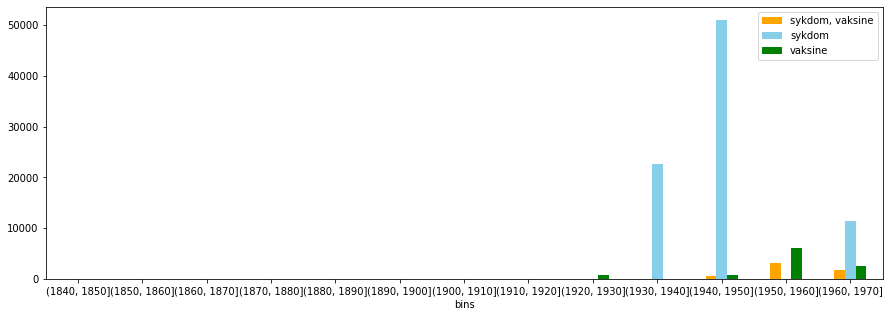

In [44]:
phrase_plots([['sykdom', 'vaksine'],['sykdom'],['vaksine']], title='*', colours=['orange', 'skyblue','green'], fra=1840, til=1980, step=10)

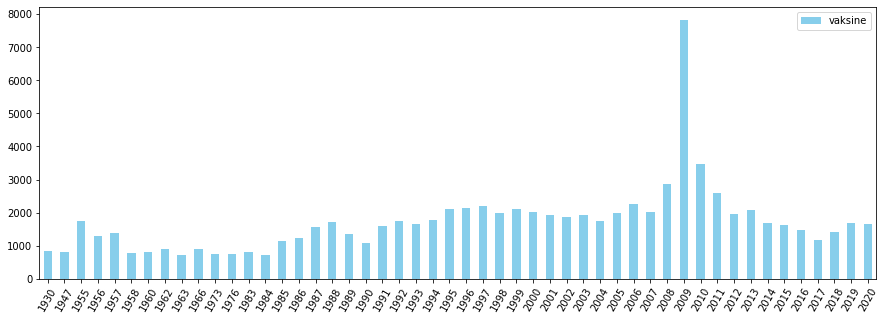

In [45]:
phrase_plots_anno([['vaksine']], title='*', fra=1945, til=2020,  rot=60, colours=['skyblue'])

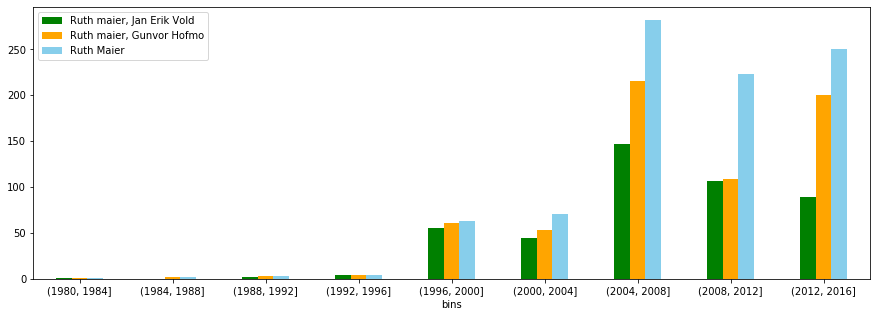

In [36]:
phrase_plots([["Ruth maier", 'Jan Erik Vold'], ['Ruth maier', 'Gunvor Hofmo'],['Ruth Maier']], title='*', colours=['green', 'orange', 'skyblue'], fra=1980, til=2020, step=4)